# positive dataset
! wget http://www.csbio.sjtu.edu.cn/bioinf/LR_PPI/Supp-A.doc

! antiword data/ppi/Supp-A.doc > data/ppi/Supp-A.txt
# negative dataset
! wget http://www.csbio.sjtu.edu.cn/bioinf/LR_PPI/Supp-B.doc

! antiword data/ppi/Supp-B.doc > data/ppi/Supp-B.txt

In [9]:
import os
import sys
import time
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split

In [64]:
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [10]:
def read_sequence():
    digits = {}
    for i in range(9):
        digits[str(i + 1)] = ""
    files = ["Supp-A.txt", "Supp-B.txt"]
    types = [1, 0]
    skip_lines = [9, 8]
    pairs = []
    proteins = {}
    interactions = []
    for _, file in enumerate(files):
        count = 0
        eof=False
        with open(f"data/ppi/{file}", "r") as doc:
            print(file)
            for i in range(skip_lines[_]):
                line = doc.readline()
            while True:
                ids = line.split()[1:]
                pairs.append(ids)
                # ">ID1" line
                line = doc.readline()
                for i, id in enumerate(ids):
                    # read sequence for the first protein
                    sequence = ""
                    while True:
                        line = doc.readline()
                        # break when 1. ">ID2" or next pair or EOF is read
                        if not line or line[0] == ">" or line[0] in digits:
                            if id not in proteins:
                                proteins[id] = sequence
                            if not line:
                                eof=True
                            elif line[0] == ">":
                                count += 1
                            break
                        sequence += line.rstrip("\n")
                    # print(count, id, sequence)
                    if eof:
                        break
                if eof:
                    interactions += [types[_]] * count
                    break
    return proteins, pairs, interactions

In [11]:
proteins, pairs, interactions = read_sequence()

Supp-A.txt
Supp-B.txt


In [12]:
to_remove = {}
for k, v in proteins.items():
    if len(v) < 50:
        to_remove[k] = ""
        continue
    for l in v:
        if l == "U":
            to_remove[k] = ""

In [13]:
for i in range(len(pairs) - 1, -1, -1):
    id1, id2 = pairs[i]
    if id1 in to_remove or id2 in to_remove:
        del pairs[i], interactions[i]
for k in to_remove.keys():
    proteins.pop(k)

In [14]:
ppi = {}
for i, (pair, value) in enumerate(zip(pairs, interactions)):
    ppi[i] = {"protein 1": pair[0], "protein 2": pair[1], "interaction": value}
protein_df = pd.DataFrame(proteins, index=[0]).transpose()
protein_df.columns = ["sequence"]
interaction_df = pd.DataFrame(ppi).transpose()
protein_df.to_csv("data/ppi/proteins.csv")
interaction_df.to_csv("data/ppi/ppi.csv")

In [15]:
seq_len = []
for v in proteins.values():
    seq_len.append(len(v))
length = int(np.percentile(seq_len, np.arange(0, 100, 5))[-1])

In [16]:
sequences = torch.zeros((len(proteins), length), dtype=int)
for i, v in enumerate(proteins.values()):
    for j in range(len(v) if length > len(v) else length):
        sequences[i, j] = ord(v[j]) - 64


In [17]:
protein_idx = {}
count = 0
for k in proteins.keys():
    protein_idx[k] = count
    count += 1

In [18]:
targets = torch.zeros((len(interactions), 2), dtype=torch.float)
protein1 = torch.empty((len(interactions), length), dtype=torch.int64)
protein2 = torch.empty((len(interactions), length), dtype=torch.int64)
for i, (pair, value) in enumerate(zip(pairs, interactions)):
    targets[i, value] = 1
    protein1[i] = sequences[protein_idx[pair[0]]]
    protein2[i] = sequences[protein_idx[pair[1]]]

In [19]:
dataset = TensorDataset(protein1, protein2, targets)

In [20]:
if torch.cuda.is_available():
    # with Nvidia GPU
    device = "cuda"
elif torch.has_mps:
    # on Apple Silicon
    device = "mps"
else:
    # on CPU
    device = "cpu"
device = torch.device(device)

In [21]:
class PPIEncoder(torch.nn.Module):
    def __init__(self, one_hot_classes):
        self.one_hot_classes = one_hot_classes
        super().__init__()

    def forward(self, x: torch.tensor):
        return torch.nn.functional.one_hot(
            x.long(), num_classes=self.one_hot_classes
        ).type(torch.float)

In [22]:
class PPICNN(torch.nn.Module):
    def __init__(self, one_hot_classes, output_classes, input_channels=1):
        super().__init__()
        self.cnn1 = torch.nn.Sequential(
            PPIEncoder(one_hot_classes),
            # 1st CNN layer
            torch.nn.Conv1d(
                in_channels=input_channels, out_channels=30, kernel_size=2
            ),
            torch.nn.BatchNorm1d(30),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            # torch.nn.MaxPool1d(kernel_size=2, stride=2),
            # 2st CNN layer
            torch.nn.Conv1d(in_channels=30, out_channels=50, kernel_size=2),
            torch.nn.BatchNorm1d(50),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            torch.nn.MaxPool1d(kernel_size=2, stride=2),
            # 3rd CNN layer
            torch.nn.Conv1d(in_channels=50, out_channels=30, kernel_size=2),
            torch.nn.BatchNorm1d(30),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            # torch.nn.MaxPool1d(kernel_size=2),
            # 4th CNN layer
            torch.nn.Conv1d(in_channels=30, out_channels=20, kernel_size=2),
            torch.nn.BatchNorm1d(20),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            torch.nn.MaxPool1d(kernel_size=2, stride=2),
        )

        self.cnn2 = deepcopy(self.cnn1)

        self.fc = torch.nn.Sequential(
            torch.nn.Linear(200, 80),
            torch.nn.ReLU(),
            torch.nn.Dropout(),
            torch.nn.Linear(80, 40),
            torch.nn.ReLU(),
            torch.nn.Dropout(),
            torch.nn.Linear(40, output_classes),
            torch.nn.Sigmoid(),
        )


    def forward(self, protein1: torch.Tensor, protein2: torch.Tensor):
        protein1 = self.cnn1(protein1)
        protein2 = self.cnn2(protein2)
        combined = torch.cat((protein1, protein2), dim=1).flatten(1)
        return self.fc(combined)

In [23]:
model = PPICNN(26, 2, input_channels=length).to(device)

In [24]:
print(model)

PPICNN(
  (cnn1): Sequential(
    (0): PPIEncoder()
    (1): Conv1d(1563, 30, kernel_size=(2,), stride=(1,))
    (2): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Dropout(p=0.2, inplace=False)
    (5): Conv1d(30, 50, kernel_size=(2,), stride=(1,))
    (6): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv1d(50, 30, kernel_size=(2,), stride=(1,))
    (11): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): Dropout(p=0.2, inplace=False)
    (14): Conv1d(30, 20, kernel_size=(2,), stride=(1,))
    (15): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (16): ReLU()
    (17): Dropout(p=0.2, inplace=False)
    (18): MaxPool1d(kernel_size=2, stride=2, padding=0, di

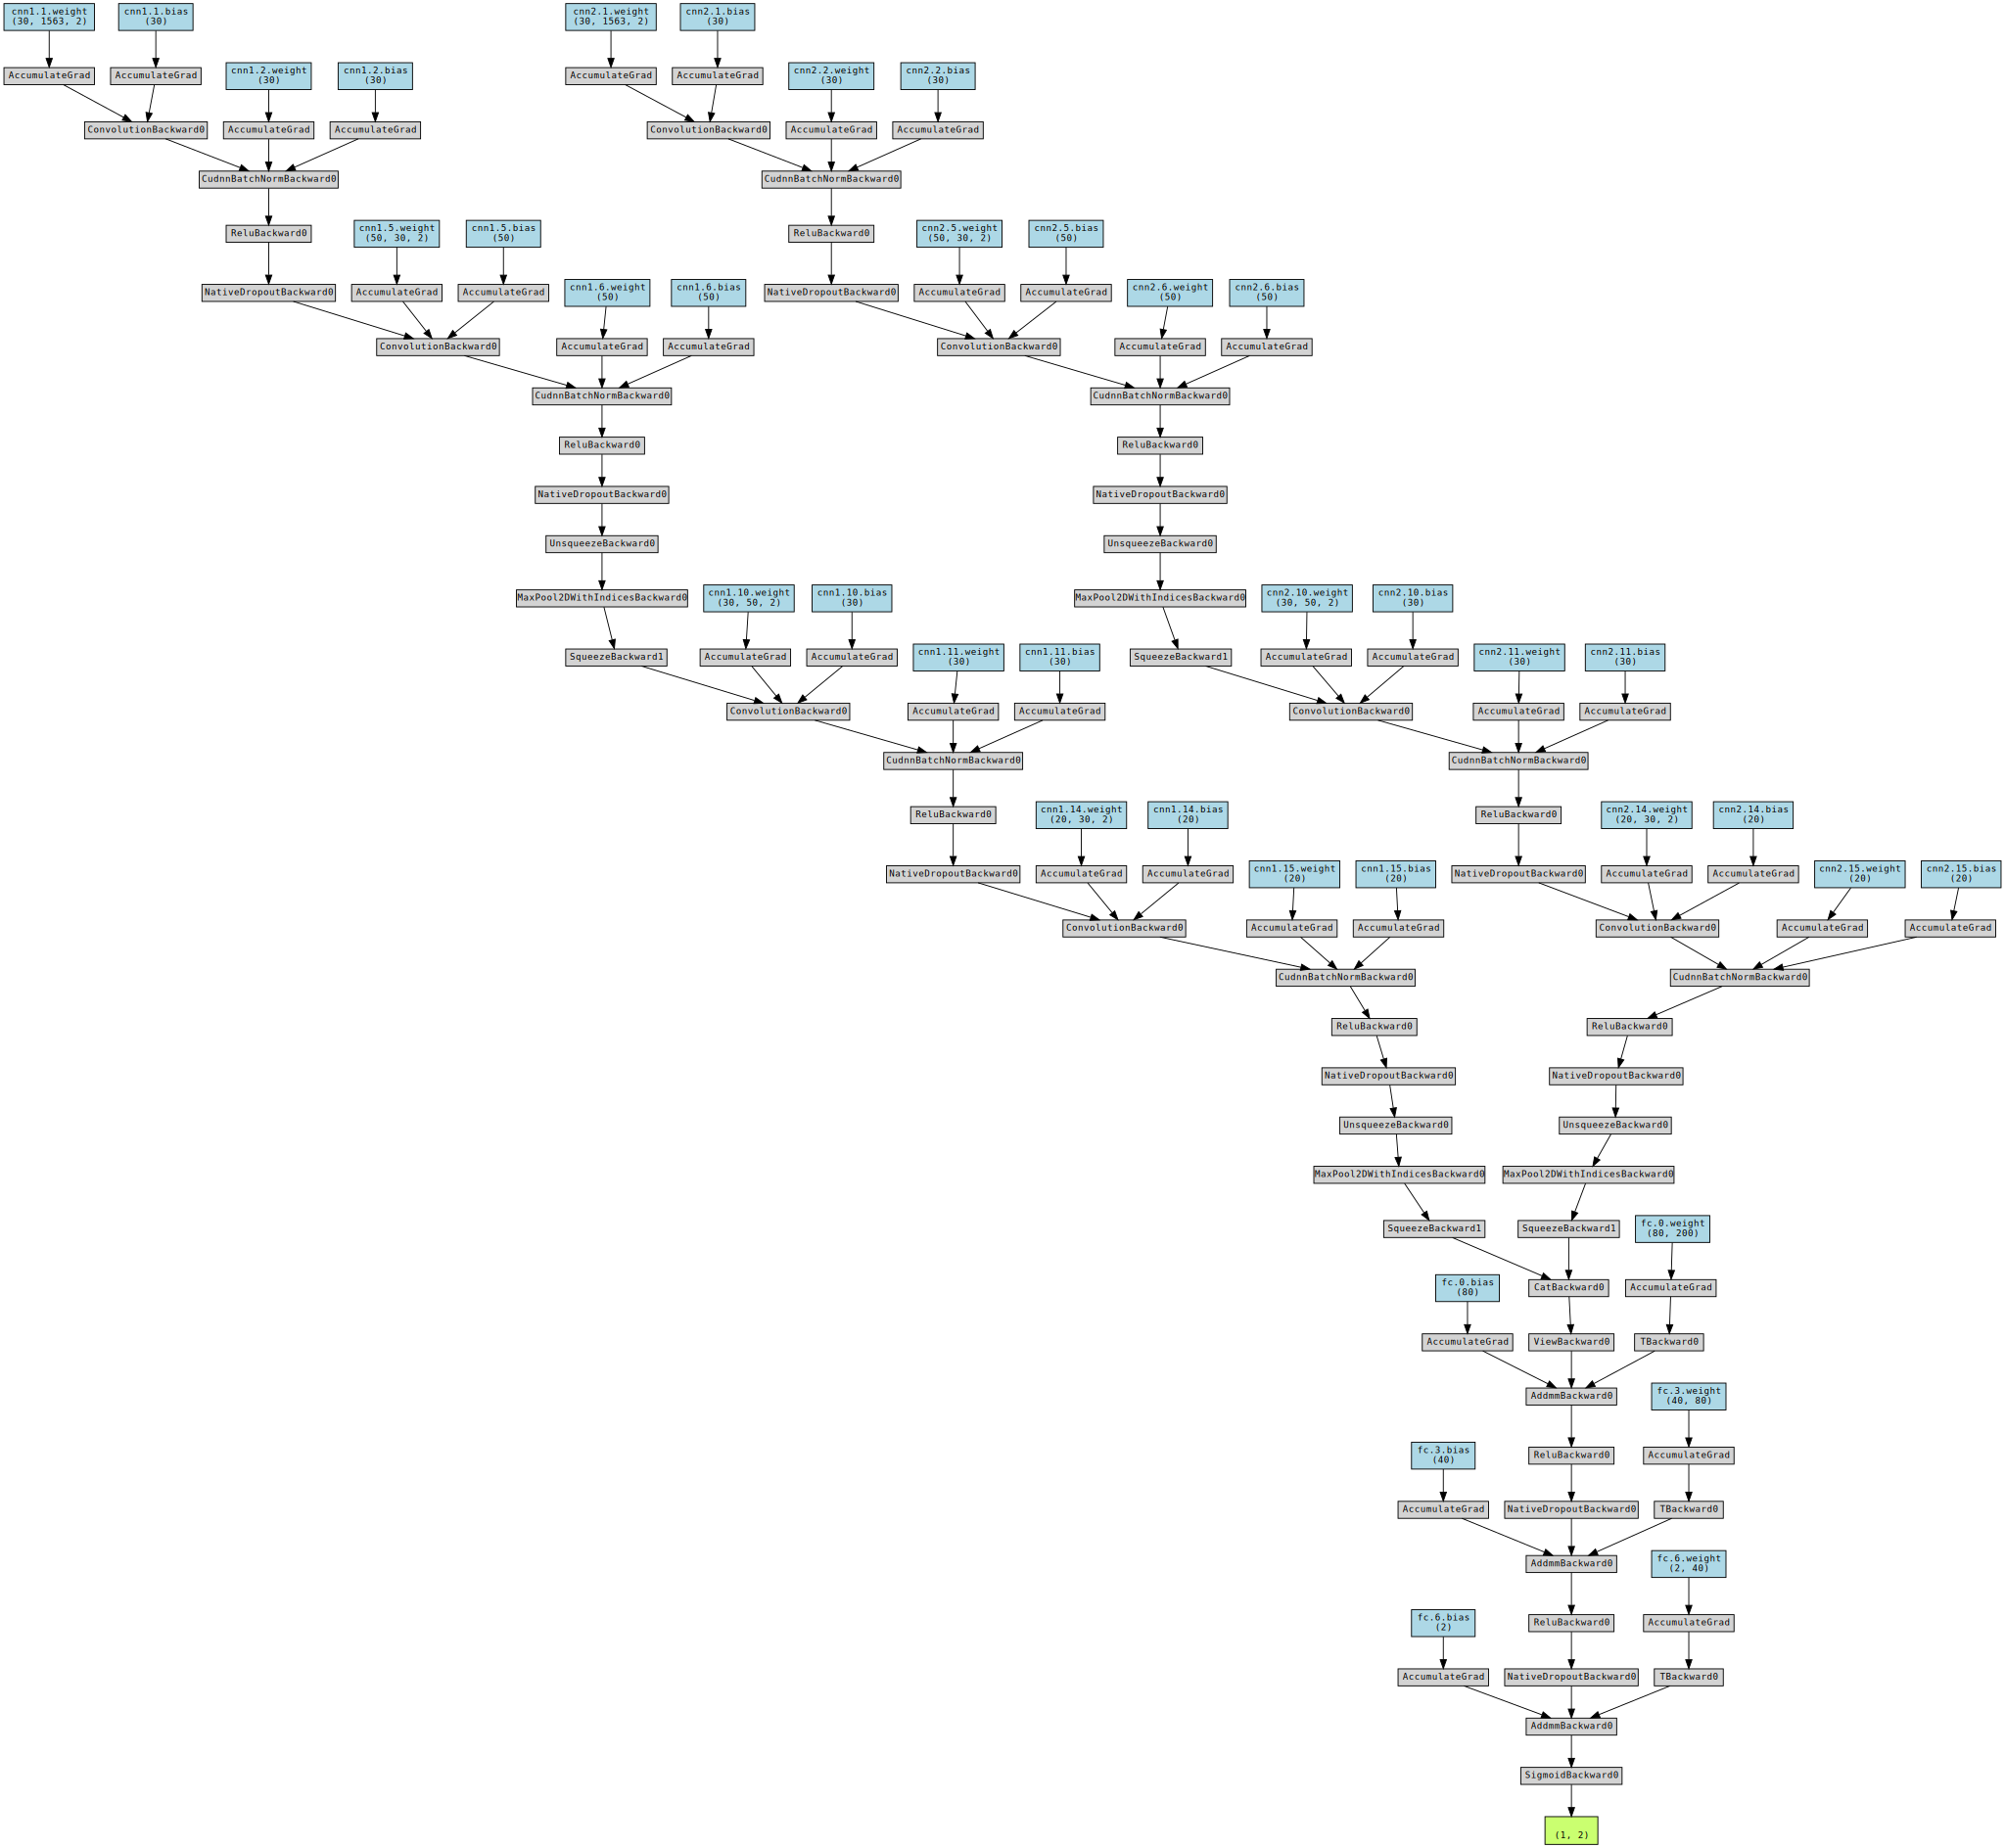

In [25]:
from torchviz import make_dot

rand_seq = torch.randint(0, 25, (1, length), dtype=int).to(device)
y = model(rand_seq, rand_seq)
make_dot(y, params=dict(model.named_parameters()))

In [26]:
test_size = int(0.1 * len(dataset))
valid_size = int(0.2 * len(dataset))
train_size = len(dataset) - test_size - valid_size
train_data, valid_data, test_data = random_split(dataset, [train_size, valid_size, test_size])

In [27]:
len(train_data), len(valid_data), len(test_data)

(51041, 14583, 7291)

In [28]:
optimizer = torch.optim.Adam(model.parameters(), 2e-3, weight_decay=2e-4)

In [29]:
loss_func = torch.nn.BCELoss()
metrics = {
    "train_loss": [],
    "valid_loss": [],
    "train_acc": [],
    "valid_acc": [],
    "best_valid_loss": None,
}

In [30]:
def regularization(
    batch_size: int,
    max_batch_size: int,
    train_data: TensorDataset,
    valid_data: TensorDataset,
    optimizer: torch.optim,
    model: torch.nn.Module,
    l2_reg=2e-4,
):
    if batch_size == max_batch_size:
        lr = optimizer.param_groups[0]["lr"]
        lr /= 2
        optimizer = torch.optim.Adam(model.parameters(), lr, weight_decay=l2_reg)
    else:
        tmp = 2 * batch_size
        if tmp > max_batch_size:
            batch_size = max_batch_size
        else:
            batch_size = tmp
    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    valid_dataloader = DataLoader(valid_data, batch_size=batch_size)
    return batch_size, train_dataloader, valid_dataloader, optimizer

In [31]:
batch_size = 32
max_batch_size = 1024
raise_batch_patience = 8
early_stop_patience = 60

In [32]:
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [33]:
raise_batch_plateau = 0
early_stop_plateau = 0
for i in range(1000):
    start_time = time.time()
    model.train()

    print(f"Current epoch {i + 1}")
    print(f"    Current batch size {batch_size}")
    print(f"    Validation loss has plateaued for {early_stop_plateau} epochs")
    train_loss = 0
    valid_loss = 0
    train_acc = 0
    valid_acc = 0

    for train_protein1, train_protein2, targets in train_dataloader:
        train_protein1 = train_protein1.to(device)
        train_protein2 = train_protein2.to(device)
        targets = targets.to(device)
        pred = model(train_protein1, train_protein2)
        batch_loss = loss_func(pred, targets)
        # print(batch_loss, pred, targets)
        train_loss += batch_loss.detach().cpu().numpy()
        train_acc += (
            (torch.argmax(pred, axis=1) == torch.argmax(targets, axis=1))
            .sum()
            .cpu()
            .numpy()
        )

        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

    with torch.no_grad():
        model.eval()

        for valid_protein1, valid_protein2, targets in valid_dataloader:
            valid_protein1 = valid_protein1.to(device)
            valid_protein2 = valid_protein2.to(device)
            targets = targets.to(device)
            pred = model(valid_protein1, valid_protein2)
            batch_loss = loss_func(pred, targets)
            valid_loss += batch_loss.cpu().numpy()
            valid_acc += (
                (torch.argmax(pred, axis=1) == torch.argmax(targets, axis=1))
                .sum()
                .cpu()
                .numpy()
            )

    train_loss /= len(train_dataloader)
    valid_loss /= len(valid_dataloader)
    train_acc /= len(train_data)
    valid_acc /= len(valid_data)

    print(f"    Training loss: {train_loss}")
    print(f"    Training accuracy: {train_acc}")
    print(f"    Validation loss: {valid_loss}")
    print(f"    Validation accuracy: {valid_acc}")
    metrics["train_loss"].append(train_loss)
    metrics["valid_loss"].append(valid_loss)
    metrics["train_acc"].append(train_acc)
    metrics["valid_acc"].append(valid_acc)

    if metrics["best_valid_loss"] is None or metrics["best_valid_loss"] > valid_loss:
        raise_batch_plateau = 0
        early_stop_plateau = 0
        metrics["best_valid_loss"] = valid_loss
        best_parameters = model.state_dict()
    else:
        raise_batch_plateau += 1
        early_stop_plateau += 1

    if raise_batch_plateau == raise_batch_patience:
        batch_size, train_dataloader, valid_dataloader, optimizer = regularization(
            batch_size, max_batch_size, train_data, valid_data, optimizer, model
        )
        raise_batch_plateau = 0

    if early_stop_plateau == early_stop_patience:
        print(
            f"Early stopping after no improvements in the validation loss for {early_stop_patience} epochs."
        )
        model.load_state_dict(best_parameters)
        break
    print(f"    Best validation loss so far: {metrics['best_valid_loss']}")
    print(f"    Epoch time: {time.time() - start_time}")
else:
    print(f"Best validation loss: {metrics['best_valid_loss']}")
    print(f"Total number of epochs: {i + 1} seconds")

Current epoch 1
    Current batch size 32
    Validation loss has plateaued for 0 epochs


    Training loss: 0.3683407397679331
    Training accuracy: 0.8278246899551341
    Validation loss: 0.14916993617978797
    Validation accuracy: 0.9509017348967976
    Best validation loss so far: 0.14916993617978797
    Epoch time: 17.75820255279541
Current epoch 2
    Current batch size 32
    Validation loss has plateaued for 0 epochs
    Training loss: 0.1534857010179407
    Training accuracy: 0.9502360847162086
    Validation loss: 0.10900586530394656
    Validation accuracy: 0.9663992319824453
    Best validation loss so far: 0.10900586530394656
    Epoch time: 16.510152339935303
Current epoch 3
    Current batch size 32
    Validation loss has plateaued for 0 epochs
    Training loss: 0.11228975994155899
    Training accuracy: 0.9659489430066025
    Validation loss: 0.09190676893769323
    Validation accuracy: 0.9726393746142769
    Best validation loss so far: 0.09190676893769323
    Epoch time: 17.22013568878174
Current epoch 4
    Current batch size 32
    Validation loss ha

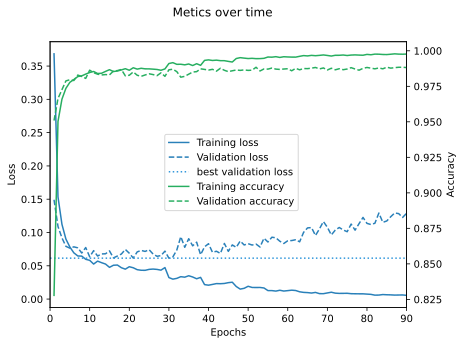

In [65]:
n_epoch = len(metrics["train_loss"])
epochs = list(range(1, n_epoch + 1))
fig, ax = plt.subplots()
fig.suptitle("Metics over time")
ax.set_xlim([0, n_epoch])
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.plot(epochs, metrics["train_loss"], c="#2980b9", label="Training loss")
ax.plot(epochs, metrics["valid_loss"], c="#2980b9", ls="--", label="Validation loss")
ax.axhline(metrics["best_valid_loss"], c="#3498db", ls=":", label="best validation loss")
ax2 = ax.twinx()
ax2.set_ylabel("Accuracy")
ax2.plot(epochs, metrics["train_acc"], c="#27ae60", label="Training accuracy")
ax2.plot(epochs, metrics["valid_acc"], c="#27ae60", ls="--", label="Validation accuracy")
fig.legend(loc=10)

In [66]:
with torch.no_grad():
    model.eval()

    test_loss = 0
    test_acc =0
    predicted = np.empty(0)
    true = np.empty(0)
    
    for (test_protein1, test_protein2, targets) in test_dataloader:
        test_protein1 = test_protein1.to(device)
        test_protein2 = test_protein2.to(device)
        targets = targets.to(device)
        pred = model(test_protein1, test_protein2)
        batch_loss = loss_func(pred, targets)
        test_loss += batch_loss.cpu().numpy()
        predicted_label = torch.argmax(pred, axis=1).cpu().numpy()
        true_label = torch.argmax(targets, axis=1).cpu().numpy()
        predicted = np.append(predicted, predicted_label)
        true = np.append(true, true_label)
        test_acc += (predicted_label == true_label).sum()
print(test_loss / len(test_dataloader), test_acc / len(test_data))

0.1437098534805827 0.9849129063228638


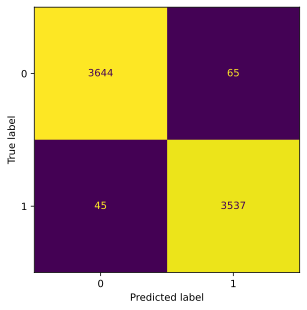

In [67]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(predicted, true)
disp = ConfusionMatrixDisplay(cm)
disp.plot(colorbar=False)